In [1]:
from symbolic_regression.methods.gp import GP
from symbolic_regression.methods.gpshap import GPSHAP
from symbolic_regression.utils.pysr_utils import nrmse_loss, train_val_test_split
from symbolic_regression.datasets import load_datasets
from symbolic_regression.feature_selections.shap import SHAP

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

sns.set_theme()
warnings.filterwarnings("ignore", category=UserWarning, module="pysr")
warnings.filterwarnings("ignore", category=RuntimeWarning)

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
n_runs = 2

pysr_params = {
    "populations": 1,
    "population_size": 20,
    "niterations": 50,
    "binary_operators": ["+", "-", "*"],
    "unary_operators": ["sqrt", "inv(x) = 1/x"],
    "extra_sympy_mappings": {"inv": lambda x: 1/x},
    "verbosity": 0
}

basic_params = {
    "loss_function": nrmse_loss,
    "record_interval": 5,
    "pysr_params": pysr_params,
}

dataset_names = [
    "F1",
    # "F2",
    # ("4544_GeographicalOriginalofMusic", "4544_GOM"),
    # "505_tecator",
    # ("Communities and Crime", "CCN"),
    # ("Communities and Crime Unnormalized", "CCUN"),
]

datasets = load_datasets(dataset_names)
width = max([round(len(name)+10, -1) for name in datasets.keys()])

datasets.keys()

dict_keys(['F1'])

In [5]:
gp = GP(**basic_params)
gpshp = GPSHAP(**basic_params)

shap = SHAP()

n_records = gp.n_records

methods = {
    "GP": gp,
    "GPSHAP": gpshp,
}

In [ ]:
results = {}
equations = {}
features = {}

for dataset_name, dataset in datasets.items():
    results[dataset_name] = {}
    equations[dataset_name] = {}
    features[dataset_name] = {}

    X = dataset["X"]
    y = dataset["y"]

    for method_name, method in methods.items():
        results[dataset_name][method_name] = {
            "training_losses": np.empty((n_runs, n_records)),
            "validation_losses": np.empty((n_runs, n_records)),
            "test_losses": np.empty((n_runs, n_records)),
        }
        equations[dataset_name][method_name] = []
        features[dataset_name][method_name] = []

        print(f"Running {method_name} on {dataset_name:<{width}}", end="")

        for run in range(n_runs):
            print(".", end="")

            train_val_test_set = train_val_test_split(X, y)

            temp_losses, temp_best_eqs, temp_features = method.run(
                train_val_test_set
            )

            results[dataset_name][method_name]["training_losses"][run, :] = temp_losses[0]
            results[dataset_name][method_name]["validation_losses"][run, :] = temp_losses[1]
            results[dataset_name][method_name]["test_losses"][run, :] = temp_losses[2]
            equations[dataset_name][method_name].append(temp_best_eqs)
            features[dataset_name][method_name].append(features)

        print("Done")

Running GP on F1        .Done


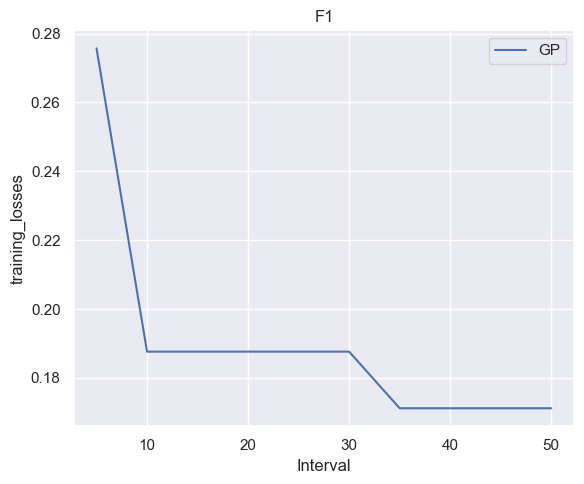

In [16]:
metrics = 'training_losses'
# metrics = 'validation_losses'
# metrics = 'test_losses'
n_datasets = len(results)
record_interval = basic_params['record_interval']
fig, axes = plt.subplots(1, n_datasets, figsize=(6 * n_datasets, 5))

if n_datasets == 1:
    axes = [axes]  # Ensure axes is always iterable

for ax, (dataset_name, dataset_results) in zip(axes, results.items()):
    # Get the number of intervals from any method (they should all be the same)
    method = next(iter(dataset_results))
    length = len(dataset_results[method][metrics].mean(axis=0))


    for method in dataset_results.keys():
        ax.plot(
            range(record_interval, length * record_interval + 1, record_interval),
            np.mean(dataset_results[method][metrics], axis=0),
            # dataset_results[method][metrics],
            label=method
        )
    ax.set_title(dataset_name)
    ax.set_xlabel("Interval")
    # ax.set_yscale("log")
    ax.legend()

axes[0].set_ylabel(metrics)
plt.tight_layout()

plt.show()

In [28]:
X_train = train_val_test_set[0]
gp_equation = equations["F1"]["GP"][0][0]

a = shap._get_shap_values(
    X_train=X_train,
    gp_equation=gp_equation
)

In [33]:
b = np.mean(a[1], axis=0)

In [58]:
c = zip(a[0], b)

for xx in c:
    print(type(xx[1]))
    # print(f"{var_name:>10}: {shap_value}")

<class 'numpy.float64'>
<class 'numpy.float64'>


In [54]:
c = zip(a[0], b)
print(tuple(c))

(('noise_11', 1.2824888235462485e-15), ('noise_23', -1.2824917511695833e-15))


In [61]:
type(b)

numpy.ndarray

In [67]:
type(y)

numpy.ndarray